In [103]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import string

#import sys
#!{sys.executable} -m pip install nltk
#!{sys.executable} -m textblob.download_corpora
#!{sys.executable} -m pip install pyspellchecker
#!{sys.executable} -m pip install wordcloud 
#nltk.download('words')
#nltk.download('tagsets')

import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [104]:
## ------------- Load Data -------------- ##
corpus = pd.read_csv('https://raw.githubusercontent.com/kitsamho/songlyrics_univeral_sentence_encoder/master/Lyric_data/lyrics.csv')
corpus

## ------------ Chosen Data ------------- ##
pre_pro_corpus = corpus.copy()        # copy for preprocessing 
pre_pro_corpus.drop(columns=['lyric_count','lyric_count_norm'], inplace=True)

In [105]:
## ---------- First Impression ---------- ##
print(pre_pro_corpus.info())
print(f"\nTotal No.of Artists: {len(pre_pro_corpus['artist'].unique())}")    # No. of artists
print(f"\n Types of Genre: {pre_pro_corpus['genre'].unique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  3288 non-null   object
 1   song    3282 non-null   object
 2   lyrics  3288 non-null   object
 3   genre   3288 non-null   object
dtypes: object(4)
memory usage: 102.9+ KB
None

Total No.of Artists: 123

 Types of Genre: ['pop' 'death-metal' 'rock' 'r&b/soul' 'hip-hop/rap' 'alternative' 'metal'
 'punk' 'pop/rock']


In [106]:
###       First Round of Cleaning       ###

## ------- Songs - Null & Rename ------- ##
location = np.where((pre_pro_corpus['song'].isnull())==True)[0]        # missing_titles
tracks = pre_pro_corpus.loc[pre_pro_corpus['song'] == 'Track'].index   # change_title

missing_titles = ["waking up is vegas", "8", "13", "22", "60%", "911"]
change_title = ["ready for it?", "call it what you want", "don't blame me", "babylon", "1000 doves", "free woman"]
for itr in range(6):
    pre_pro_corpus['song'].loc[location[itr]] = missing_titles[itr]
    pre_pro_corpus['song'].loc[tracks[itr]] = change_title[itr]

    #pre_pro_corpus.info()    # Self-check

## -------- Lyrics - Duplicated -------- ##
inst = pre_pro_corpus.loc[pre_pro_corpus['lyrics'] == 'instrumental'].index       # dropping 'instrumental' lyric
pre_pro_corpus.drop(index = inst, axis = 0, inplace = True)
dups = pre_pro_corpus[pre_pro_corpus['lyrics'].duplicated() == True].index        # dropping duplicated songs
pre_pro_corpus.drop(index = dups, axis = 0, inplace = True)

pre_pro_corpus.info()    # Self-check

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3254 entries, 0 to 3287
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  3254 non-null   object
 1   song    3254 non-null   object
 2   lyrics  3254 non-null   object
 3   genre   3254 non-null   object
dtypes: object(4)
memory usage: 127.1+ KB


In [107]:
## --------- Target Label Encoder --------- ##
genre_labels = pre_pro_corpus.genre.unique()                                # Genre list
new_genre = {'pop': 0, 'death-metal': 1, 'rock': 2,'r&b/soul': 3,           # Label encoding
            'hip-hop/rap': 4, 'alternative': 5, 'metal': 6, 'punk': 7,
            'pop/rock': 8}


pre_pro_corpus.genre = pre_pro_corpus.genre.apply(lambda x: new_genre[x])
#pre_pro_corpus.genre.value_counts()

In [108]:
###       Second Round of Cleaning       ###

### ------ Remove Non-English Words ------ ##             # Not-efficient, "[a-zA-Z]+" was chosen instead
#def language(check):
#    wanted_words = set(nltk.corpus.words.words())  
#    clean = " ".join(w for w in nltk.wordpunct_tokenize(check)
#                     if w in wanted_words or not w.isalpha())  
#    return clean

## -------------- Dusting --------------- ##
# pre_pro_corpus[pre_pro_corpus['lyrics'] == '\[.*?\]']   # Checking for '[]' in the data (i.e. '[intro]')
def lyric_cleaning(words):
    words = words.lower()     
    words = re.sub('[%s]' %re.escape(string.punctuation), '', words)     # Removal of punctuation marks
    words = re.sub('\w*\d\w*', '', words)                                # Removal of number mixed with letter
    str = re.findall("[a-zA-Z]+",words)                                  # Removal of non-English words (Replacing 'language')
    return " ".join(str)

### ---------- Spell Correction ---------- ##             # Not-efficient  
#def spell_check(lyric):
#    words = words.lower()                                # .lower() must be applied before .correct() 
#    song = TextBlob(lyric)                           
#    corrected_song = song.correct()                
#    return str(corrected_song)

## ------Tokenization & Stop Words ------ ##
def remove_stopwords(lyric):
    stop_words = set(stopwords.words('english'))
    song = TextBlob(lyric)
    tokens = song.words
    ok = []
    for token in tokens:
        if token not in stop_words:
            ok.append(token)
    return ok

## ------------ Lemmatizion ------------- ##
def lemmatiz(tokens):
    lemma_list = []
    for token in tokens:
        lemma_list.append(Word(token).lemmatize("VB"))
    return " ".join(lemma_list)


lyrics = pre_pro_corpus.lyrics.apply(lyric_cleaning).apply(remove_stopwords).apply(lemmatiz)
#lyrics

In [109]:
###        Third Round of Cleaning       ###

## ------------ Song length ------------- ##
def count_words(lyrics):
    return len(lyrics.split(' '))

## ------------ C'est la Vi ------------- ##
rotten = []
def el_chopo(data_frame, threshold):
    return data_frame[data_frame.lyrics_count > threshold]
  

pre_pro_corpus.lyrics = lyrics
pre_pro_corpus['lyrics_count'] = lyrics.apply(count_words)
#sortted = pre_pro_corpus.sort_values().unique()[:20]          # Choosing threshold
clean_corpus = el_chopo(pre_pro_corpus, 15)
clean_corpus

#x = clean_corpus[clean_corpus.genre == 4]      # test

,artist,song,lyrics,genre,lyrics_count
0,Katy Perry,The One That Got Away acoustic,summer high school first meet would makeout mu...,0,103
1,Katy Perry,Who Am I Living For,yeah yeah yeah feel phoenix inside march alone...,0,86
2,Katy Perry,Daisies,tell dream start laughin guess mind til actual...,0,66
3,Katy Perry,Witness,lose today would stay could love enough stimul...,0,91
4,Katy Perry,Starstrukk,nice legs daisy dukes make man go way come lik...,0,80
...,...,...,...,...,...
3283,Alicia Keys,A Woman s Worth,could buy diamonds could buy pearl take cruise...,3,221
3284,Alicia Keys,Empire State of Mind Pt,oh new york grow town famous place movie scene...,3,113
3285,Alicia Keys,Try Sleeping With a Broken Heart,even million miles away still feel bed near to...,3,109
3286,Alicia Keys,Like Home,yeah shout everybody trip agree feel like some...,3,289


In [110]:
###              Gender Drop             ###
clean_corpus = clean_corpus[(clean_corpus.genre != new_genre['pop']) & (clean_corpus.genre != new_genre['pop/rock'])]
new_genre_short = {'Death-Metal': 1, 'Rock': 2,'R&B/Soul': 3,                 
            'Hip-Hop/Rap': 4, 'Alternative': 5, 'Metal': 6, 'Punk': 7}
new_genre_short_inv = {value: key for key, value in new_genre_short.items()}

short_names = list(new_genre_short.keys())                                         # Genres after filtering
clean_corpus.genre = clean_corpus.genre.apply(lambda x: new_genre_short_inv[x])    # Run only once or you'll get an error
clean_corpus

D:\anaconda\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,artist,song,lyrics,genre,lyrics_count
167,Meshuggah,BENZIN RMX BY MESHUGGAH,ich brauche zeit kein heroin kein alkohol kein...,Death-Metal,109
168,Meshuggah,Bleed,beam fire sweep head thrust pain increasingly ...,Death-Metal,105
169,Meshuggah,I Am Colossus,great leviathan insatiable colossus titanic en...,Death-Metal,94
170,Meshuggah,Our Rage Won t Die,cry need disguise evade hide run til hit water...,Death-Metal,71
171,Meshuggah,Born in Dissonance,origin increate see come thousand years every ...,Death-Metal,65
...,...,...,...,...,...
3283,Alicia Keys,A Woman s Worth,could buy diamonds could buy pearl take cruise...,R&B/Soul,221
3284,Alicia Keys,Empire State of Mind Pt,oh new york grow town famous place movie scene...,R&B/Soul,113
3285,Alicia Keys,Try Sleeping With a Broken Heart,even million miles away still feel bed near to...,R&B/Soul,109
3286,Alicia Keys,Like Home,yeah shout everybody trip agree feel like some...,R&B/Soul,289


In [111]:
###      Basic Sentimental Analysis      ###

senti_corpus = clean_corpus.copy()

## ----------- Sentiment Calc ----------- ##
def sentiment(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

senti_corpus['Polarity']     = senti_corpus.lyrics.apply(sentiment).apply(lambda x: x[0])
senti_corpus['Subjectivity'] = senti_corpus.lyrics.apply(sentiment).apply(lambda x: x[1])

## ------------ Edge Cases  ------------ ##
senti_corpus[(senti_corpus.Polarity == -1) | (senti_corpus.Polarity == 1) | (senti_corpus.Polarity == 0)]
non_english_songs = ['BENZIN RMX BY MESHUGGAH', 'Let It Go Feat Snoop Dogg', 'La Mer', 'Halloween',
                     'Como Yo Nadie Te Ha Amado', 'Operators Manual']
senti_corpus = senti_corpus[~senti_corpus.song.isin(non_english_songs)]
senti_corpus.reset_index(drop=True, inplace=True)     # Reset index count
senti_corpus

,artist,song,lyrics,genre,lyrics_count,Polarity,Subjectivity
0,Meshuggah,Bleed,beam fire sweep head thrust pain increasingly ...,Death-Metal,105,-0.118750,0.272917
1,Meshuggah,I Am Colossus,great leviathan insatiable colossus titanic en...,Death-Metal,94,0.112374,0.583333
2,Meshuggah,Our Rage Won t Die,cry need disguise evade hide run til hit water...,Death-Metal,71,0.281250,0.548611
3,Meshuggah,Born in Dissonance,origin increate see come thousand years every ...,Death-Metal,65,-0.150000,0.458333
4,Meshuggah,Clockworks,dismantle clockwork make cynic pallet wheel cl...,Death-Metal,89,-0.060000,0.551111
...,...,...,...,...,...,...,...
2422,Alicia Keys,A Woman s Worth,could buy diamonds could buy pearl take cruise...,R&B/Soul,221,0.185099,0.335961
2423,Alicia Keys,Empire State of Mind Pt,oh new york grow town famous place movie scene...,R&B/Soul,113,0.104809,0.522069
2424,Alicia Keys,Try Sleeping With a Broken Heart,even million miles away still feel bed near to...,R&B/Soul,109,0.230952,0.510317
2425,Alicia Keys,Like Home,yeah shout everybody trip agree feel like some...,R&B/Soul,289,-0.012576,0.471923


Text(0, 0.5, 'factual information <--- Subjectivity ---> personal opinion/emotion')

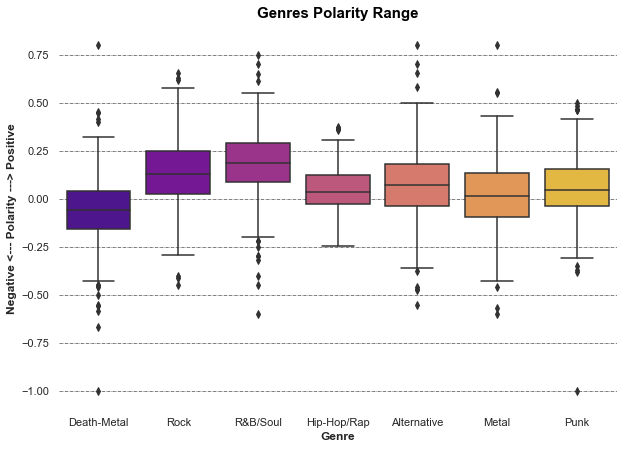

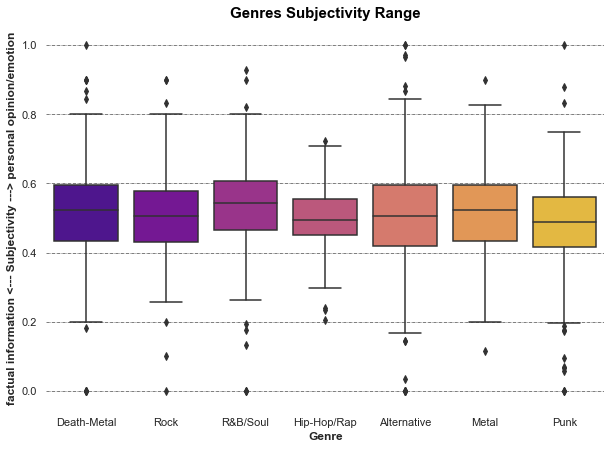

In [112]:
## ------------- Box Plots ------------- ##

## -------- Genres Polarity Range------- ##
fig, ax = plt.subplots(figsize=(10,7))                                       
sns.boxplot(y='Polarity', x='genre', data=senti_corpus, palette='plasma')
ax.set_title('Genres Polarity Range',backgroundcolor='white',
             fontsize=15,weight='bold',color='black',loc='center',pad=10)
plt.box(False)
ax.yaxis.grid(linewidth=0.5,color='black',linestyle='-.')
ax.set_axisbelow(True)
ax.set_xlabel('Genre',weight='bold',size=12)
ax.set_ylabel('Negative <--- Polarity ---> Positive',
              weight='bold',size=12)

## ----- Genres Subjectivity Range ----- ##
fig, ax = plt.subplots(figsize=(10,7))            
sns.boxplot(y='Subjectivity', x='genre', data=senti_corpus, palette='plasma')
ax.set_title('Genres Subjectivity Range',backgroundcolor='white',
             fontsize=15,weight='bold',color='black',loc='center',pad=10)
plt.box(False)
ax.yaxis.grid(linewidth=0.5,color='black',linestyle='-.')
ax.set_axisbelow(True)
ax.set_xlabel('Genre',weight='bold',size=12)
ax.set_ylabel('factual information <--- Subjectivity ---> personal opinion/emotion',weight='bold',size=12)

### ----- R&B/Soul Polarity Range ----- ##
#chosen = senti_corpus[senti_corpus.genre == 'R&B/Soul']
#
#fig, ax = plt.subplots(figsize=(9,5))
#sns.boxplot(y='artist', x='Polarity', data=chosen, palette='plasma')
#ax.set_title('Artist\'s Polarity Range - R&B/Soul',backgroundcolor='white',
#             fontsize=15,weight='bold',color='black',loc='center',pad=10)
#plt.box(False)
#ax.yaxis.grid(linewidth=0.5,color='black',linestyle='-.')
#ax.set_axisbelow(True)
#ax.set_xlabel('Polarity',weight='bold',size=12)
#ax.set_ylabel('Artist',weight='bold',size=12)

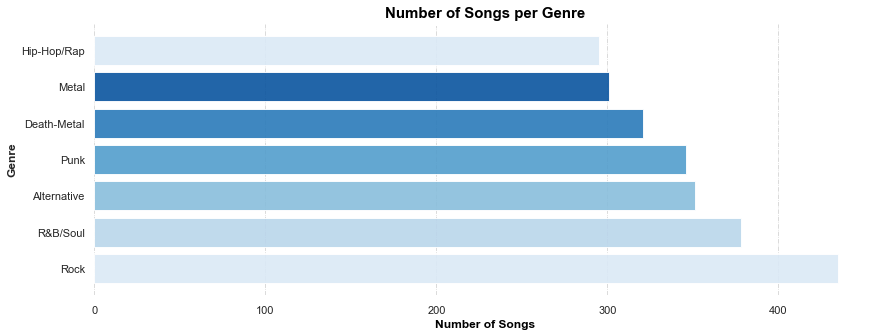

<Figure size 432x288 with 0 Axes>

In [113]:
###             Exploration             ###
## -- Distribution of Songs Per Genre -- ## (Plot)

fig, ax = plt.subplots(figsize =(14, 5))
no_songs = [senti_corpus[senti_corpus.genre == genre].shape[0] for genre in short_names]
ax.barh(senti_corpus.genre.value_counts().index, senti_corpus.genre.value_counts(),
        color = sns.color_palette('Blues'), alpha=0.9)  
ax.grid(b = True, color ='grey',            
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.set_title('Number of Songs per Genre',backgroundcolor='white',
             fontsize=15,weight='bold',color='black',loc ='center')
plt.box(False)
plt.grid(False)
ax.xaxis.grid(linewidth=0.7,color='black',linestyle='-.')
ax.set_xlabel('Number of Songs', weight='bold',color='black')
ax.set_ylabel('Genre', weight='bold',)
plt.show()
sns.set(font_scale = 1)
plt.savefig(f'Number of songs per genre - with pop.pdf')

#main_artist = []    # Top artist by genre                              
#for genre in pre_pro_corpus.genre.unique():
#    main_artist.append(pre_pro_corpus[pre_pro_corpus.genre == genre].artist.value_counts()[:3])

#main_artist

In [114]:
###             Exploration             ###
## ---------- Genre Seperation --------- ##

explor = senti_corpus.copy()                    # Copy for exploration

## ---- Documents As List Or String ---- ##
def separate(df, to_string=False):
    by_genre = []
    for genre in df.genre.unique():
        lyrics = df[df.genre == genre].lyrics.values
        if to_string:
            lyrics = ' '.join(lyrics)
        by_genre.append(lyrics)
    return by_genre

## ----------- Song Counter ------------ ##
def song_counter(df):
    total = []
    for genre in df.genre.unique():
        tot_songs = df[df.genre == genre].song.count()
        total.append(tot_songs)
    return total

## ----------- Word Counter ------------ ##        
def word_counter(df):
    total = []
    for genre in df.genre.unique():
        tot_words = df[df.genre == genre].lyrics_count.sum()
        total.append(tot_words)
    return total


txt_genre = separate(explor)
txt_songs = separate(explor, to_string=True)    
song_collection = song_counter(explor)          
word_collection = word_counter(explor)          

Text(0, 0.5, 'Average No. of Words Per Song')

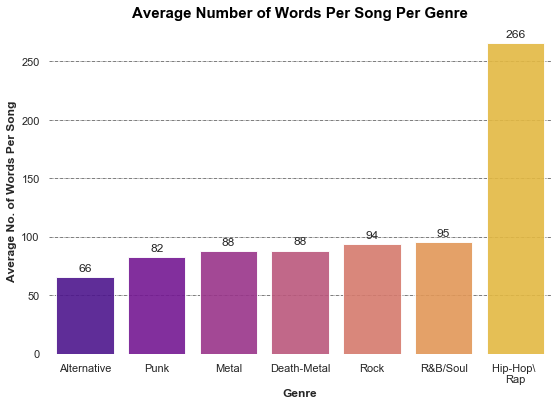

In [115]:
###                 Exploration                 ###
## -- Aaverage No. of Word Per Sond Per Genre -- ## (Plot)

avg_words_in_genre = np.array(word_collection)/np.array(song_collection)

figure_02 = {'Genre': ['Death-Metal', 'Rock','R&B/Soul',
            'Hip-Hop\ \nRap', 'Alternative', 'Metal', 'Punk'],
             'Average No. of Words Per Song': avg_words_in_genre}
df_02 = pd.DataFrame(figure_02)

fig,ax = plt.subplots(figsize=(9,6))
splot = sns.barplot(x='Genre',y='Average No. of Words Per Song',data=df_02,ci=95,ax=ax,
                    order = df_02.sort_values('Average No. of Words Per Song').Genre,
                    palette = 'plasma',  alpha=0.9)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
ax.set_title('Average Number of Words Per Song Per Genre',backgroundcolor='white',
             fontsize=15,weight='bold',color='black',loc='center',pad=10)   # style='italic'
plt.box(False)
ax.yaxis.grid(linewidth=0.5,color='black',linestyle='-.')
ax.set_axisbelow(True)
ax.set_xlabel('Genre',weight='bold',size=12)
ax.set_ylabel('Average No. of Words Per Song',weight='bold',size=12)


#df = pre_pro_corpus[(pre_pro_corpus.genre == 4) & (pre_pro_corpus.artist != 'Eminem')]     # Hip-Hop/Rap withpue Eminem
#df.lyrics_count.sum() / df.shape[0]    

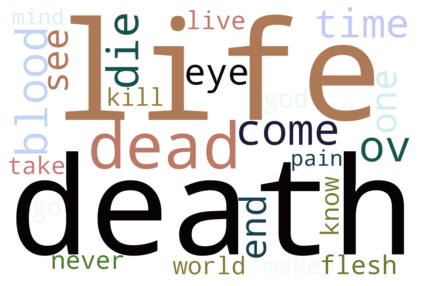

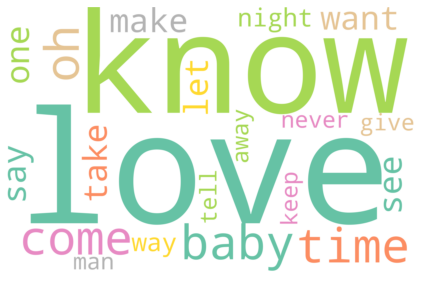

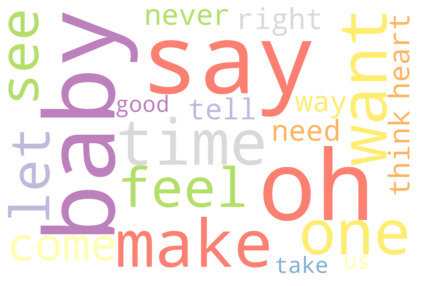

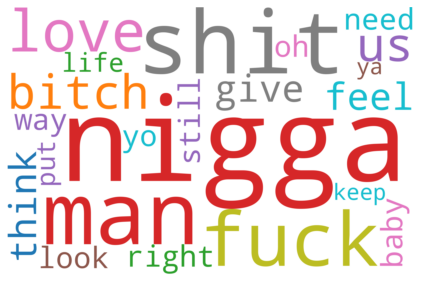

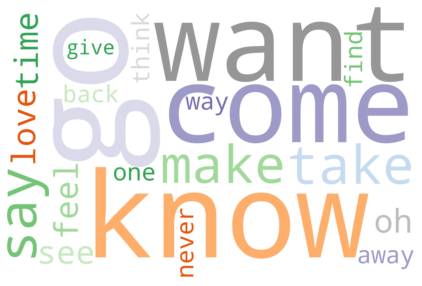

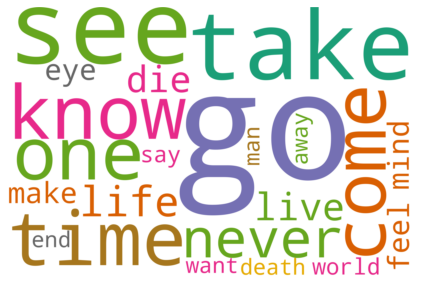

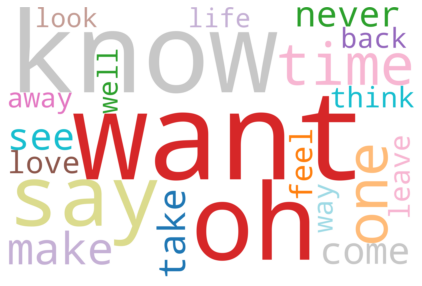

In [122]:
###             Exploration             ###
## ------------ Word Clouds ------------ ## (Plots)

## -- CountVectorizer 4 Cloud_me_baby -- ##
def data_frame(lyrics, vectorizer):
    X = vectorizer.fit_transform(lyrics).toarray()
    names = vectorizer.get_feature_names()
    df = pd.DataFrame(X, columns = names)
    return df

## -------- Most Frequent Words -------- ##
def cloud_me_baby(txt, max_feat):
    most_freq_by_genre = []
    for genre in range(len(txt)):
        genre_df = data_frame(txt[genre],CountVectorizer(max_features = max_feat, max_df = 0.6))
        #ignore terms that appear in more than 50% of the documents
        freq = genre_df[genre_df.sum().sort_values(ascending=False).index[:max_feat]].columns
        freq = ' '.join(freq)
        most_freq_by_genre.append(freq)
    return most_freq_by_genre

## --------- Sky Is The Limit ---------- ##
sky = cloud_me_baby(txt_genre, 25)
#print(sky)


## -------- Add/Remove StopWords ------- ##
#STOPWORDS.add("yeah").add("oh")

## -------- WordCloud Generator -------- ##
colormap=['cubehelix', 'Set2', 'Set3', 'tab10', 'tab20c', 'Dark2', 'tab20']

for i in range(len(sky)):                                 # Save figure of 'top words per genre'
    wordcloud = WordCloud(width = 3000, height = 2000, random_state=420,background_color='white',
                          colormap=colormap[i],collocations=False, stopwords = STOPWORDS).generate(sky[i])
    plt.figure(figsize=(8, 5))
    plt.imshow(wordcloud, interpolation='bilinear')       # Display image
    plt.axis("off")    
#plot(wordcloud)
    plt.savefig(f'{i}.pdf')
    
#    new_genre_short = {'Death-Metal': 1, 'Rock': 2,'R&B/Soul': 3,                 
#            'Hip-Hop/Rap': 4, 'Alternative': 5, 'Metal': 6, 'Punk': 7}

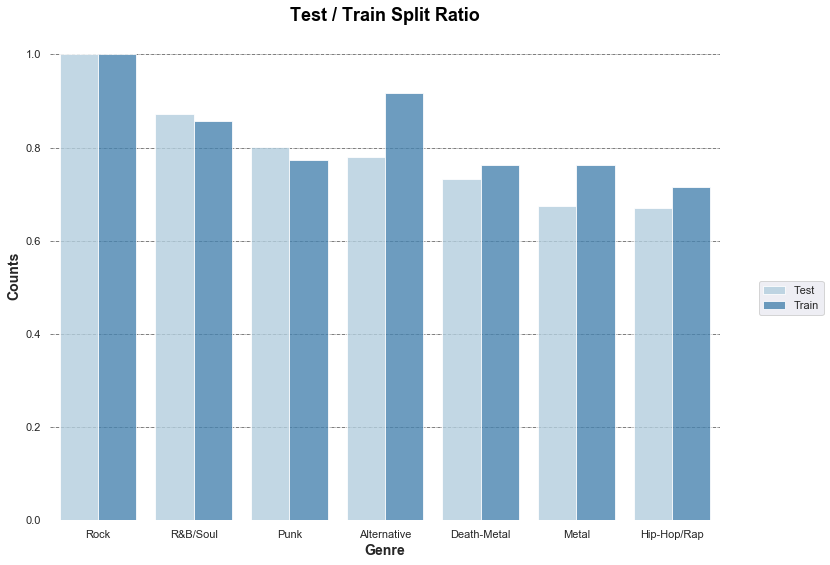

In [150]:
###               Modeling               ###

## ---------- Train/Test Split ---------- ##
X,y = explor.lyrics, explor.genre
X_train ,X_test ,y_train, y_test = train_test_split(X ,y ,test_size=0.2,random_state=40)


## ------- Train/Test Split Ratio ------- ## (Plot)
y1 = pd.DataFrame(y_train.value_counts())
y1['count'] = y1.genre.values
y1['count'] = y1['count'] / max(y1['count'])
y1.genre = y1.index
y1['Legend'] = 'Test'
y1 = y1.reset_index(drop=True)

y2 = pd.DataFrame(y_test.value_counts())
y2['count'] = y2.genre.values
y2['count'] = y2['count'] / max(y2['count'])
y2.genre = y2.index
y2['Legend'] = 'Train'
y2 = y2.reset_index(drop=True)
df = pd.concat([y1, y2])


fig, ax = plt.subplots(figsize=(12,9))
sns.barplot(x='genre', y='count', hue='Legend', data=df, palette = 'Blues', alpha = 0.8)
ax.set_title('Test / Train Split Ratio',backgroundcolor='white',
             fontsize=18,weight='bold',color='black',loc='center',pad=10)   # style='italic'
plt.box(False)
ax.yaxis.grid(linewidth=0.5,color='black',linestyle='-.')
ax.set_axisbelow(True)
ax.set_xlabel('Genre',weight='bold',size=14)
ax.set_ylabel('Counts',weight='bold',size=14)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.5)

Currently fitting: RandomForestClassifier
Currently fitting: LinearSVC
Currently fitting: MultinomialNB
Currently fitting: LogisticRegression
All Done!
                     Model  No. of Fold  Accuracy
0   RandomForestClassifier            0  0.586118
1   RandomForestClassifier            1  0.546392
2   RandomForestClassifier            2  0.556701
3   RandomForestClassifier            3  0.564433
4   RandomForestClassifier            4  0.574742
5                LinearSVC            0  0.611825
6                LinearSVC            1  0.590206
7                LinearSVC            2  0.600515
8                LinearSVC            3  0.595361
9                LinearSVC            4  0.559278
10           MultinomialNB            0  0.429306
11           MultinomialNB            1  0.456186
12           MultinomialNB            2  0.448454
13           MultinomialNB            3  0.425258
14           MultinomialNB            4  0.438144
15      LogisticRegression            0  0.63239

Text(0.5, 30.5, 'Predicted')

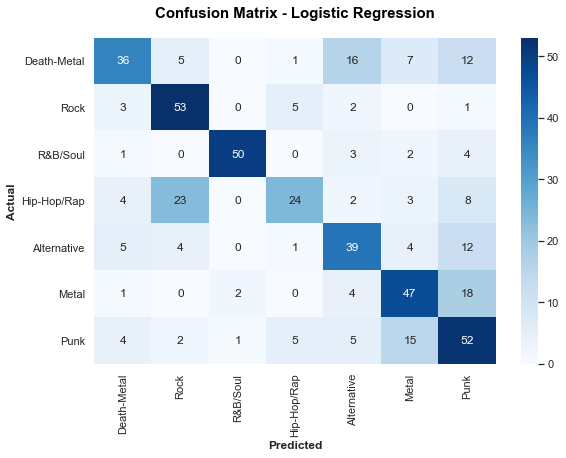

In [151]:
###               Modeling               ###
 
## ---------- TF-IDF Vectorizer --------- ##   
vectorizer = TfidfVectorizer(max_df = 0.6)               # Ignore terms that appear in more
X_train = vectorizer.fit_transform(X_train).toarray()    # than 50% of the documents
X_test = vectorizer.transform(X_test).toarray()

## --------- Train Classifiers ---------- ##
models = [RandomForestClassifier(n_estimators=100, min_samples_split=3, random_state=40),
          LinearSVC(),
          MultinomialNB(),
          LogisticRegression(random_state=40, penalty='l2')]    #  'l2' in order to avoid as much as possible over-fitting

cross_val = 5
results = []
predictions = []

for model in models:
    model_name = model.__class__.__name__                                                        # Modeling
    print ("Currently fitting: {}".format(model_name))    
    model.fit(X_train, y_train)
    predictions.append(model.predict(X_test))                                                    # Predictions
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cross_val)      # Accuracies
    for fold_idx, accuracy in enumerate(accuracies):
        results.append((model_name, fold_idx, accuracy))
print('All Done!')

## ------------- Accuracies ------------- ##
accuracy_df = pd.DataFrame(results, columns=['Model', 'No. of Fold', 'Accuracy'])
print(accuracy_df)

## ---------- Confusion Matrix ---------- ##
conf_mat = confusion_matrix(y_test, predictions[-1])                                             
fig,ax = plt.subplots(figsize=(9,6))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap="Blues",
            xticklabels=short_names, yticklabels=short_names)
ax.set_title('Confusion Matrix - Logistic Regression',backgroundcolor='white',
             fontsize=15,weight='bold',color='black',loc='center',pad=20) 
plt.ylabel('Actual', weight='bold',size=12)
plt.xlabel('Predicted', weight='bold',size=12)